This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

**Inspecting the data of the Jena weather dataset**

In [1]:
import os
fname = os.path.join("../data/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [2]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    # 舍弃掉Date Time这一列
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

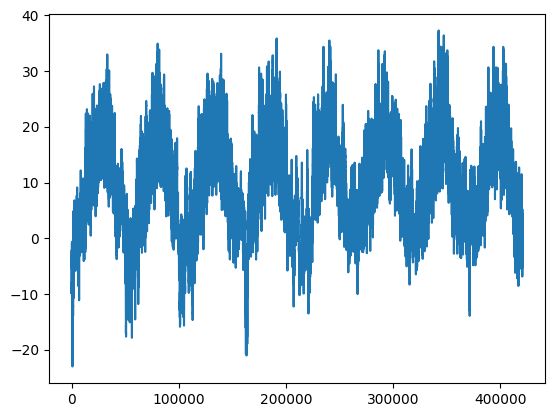

In [3]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

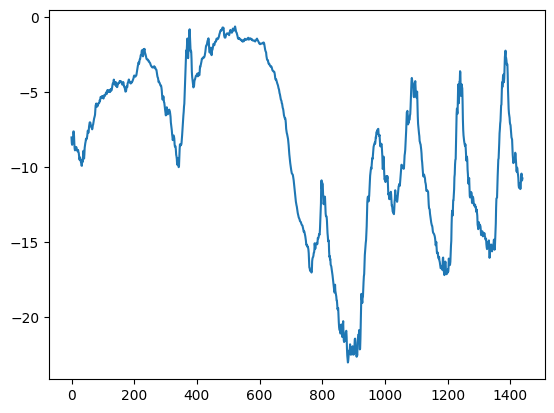

In [4]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [8]:
# 每6个数据点保留一个，即每小时采样一个数据点
sampling_rate = 6
# 给定过去5天（120小时）的观测数据
sequence_length = 120
# 序列结束24小时之后的温度
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# suffle=True表示数据被打乱
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    # 规范化    
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

# 先将数据展平，接两个Dense层，最后一层没有激活函数
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
# 使用MSE
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 8s 9ms/step - loss: 12.3123 - mae: 2.7288 - val_loss: 11.3079 - val_mae: 2.6473
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 9.1990 - mae: 2.3820 - val_loss: 11.7102 - val_mae: 2.6907
Epoch 3/10
819/819 [==============================] - 8s 9ms/step - loss: 8.3424 - mae: 2.2719 - val_loss: 11.2678 - val_mae: 2.6471
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 7.7919 - mae: 2.1976 - val_loss: 10.9955 - val_mae: 2.6211
Epoch 5/10
819/819 [==============================] - 7s 9ms/step - loss: 7.4108 - mae: 2.1462 - val_loss: 11.1819 - val_mae: 2.6327
Epoch 6/10
819/819 [==============================] - 8s 9ms/step - loss: 7.1691 - mae: 2.1119 - val_loss: 11.1049 - val_mae: 2.6225
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 6.9434 - mae: 2.0795 - val_loss: 11.4226 - val_mae: 2.6532
Epoch 8/10
819/819 [==============================] - 7s 9ms/step -

**Plotting results**

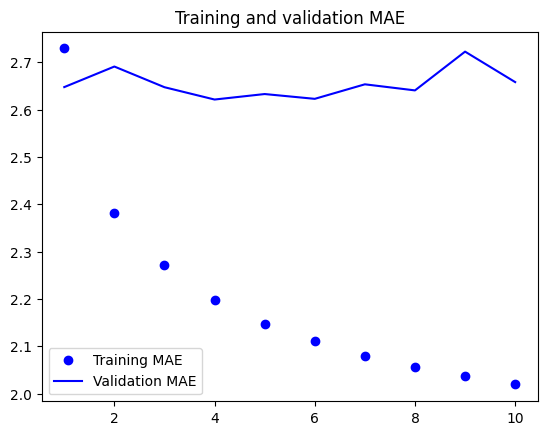

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 12ms/step - loss: 21.7735 - mae: 3.6510 - val_loss: 16.3951 - val_mae: 3.1865
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 15.3535 - mae: 3.1111 - val_loss: 17.0642 - val_mae: 3.2589
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 14.1765 - mae: 2.9876 - val_loss: 15.1275 - val_mae: 3.0595
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 13.4248 - mae: 2.9061 - val_loss: 16.2286 - val_mae: 3.1678
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 12.8978 - mae: 2.8475 - val_loss: 14.1904 - val_mae: 2.9636
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 12.4028 - mae: 2.7920 - val_loss: 14.9884 - val_mae: 3.0318
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 11.9748 - mae: 2.7404 - val_loss: 15.0762 - val_mae: 3.0420
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 13ms/step - loss: 39.4158 - mae: 4.5597 - val_loss: 11.8083 - val_mae: 2.6079
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 10.7717 - mae: 2.5552 - val_loss: 9.6669 - val_mae: 2.4043
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 9.6812 - mae: 2.4267 - val_loss: 9.8457 - val_mae: 2.4165
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 9.1593 - mae: 2.3567 - val_loss: 10.0936 - val_mae: 2.4632
Epoch 5/10
819/819 [==============================] - 10s 12ms/step - loss: 8.7542 - mae: 2.3074 - val_loss: 10.0509 - val_mae: 2.4522
Epoch 6/10
819/819 [==============================] - 10s 12ms/step - loss: 8.4186 - mae: 2.2667 - val_loss: 10.0327 - val_mae: 2.4514
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 8.1676 - mae: 2.2341 - val_loss: 10.2596 - val_mae: 2.4749
Epoch 8/10
819/819 [==============================] - 1

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [15]:
import numpy as np
timesteps = 100
# 输入特征空间的维度
input_features = 32
# 输出特征空间的维度
output_features = 64
inputs = np.random.random((timesteps, input_features))
# 初始化状态
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [16]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [17]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [19]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
# 对dense进行正则化
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 557s 678ms/step - loss: 27.3806 - mae: 3.8694 - val_loss: 10.0060 - val_mae: 2.4480
Epoch 2/50
819/819 [==============================] - 555s 678ms/step - loss: 14.7435 - mae: 2.9806 - val_loss: 9.4195 - val_mae: 2.3768
Epoch 3/50
819/819 [==============================] - 554s 676ms/step - loss: 13.8071 - mae: 2.8817 - val_loss: 9.4294 - val_mae: 2.3830
Epoch 4/50
819/819 [==============================] - 555s 677ms/step - loss: 13.1150 - mae: 2.8069 - val_loss: 9.2360 - val_mae: 2.3549
Epoch 5/50
819/819 [==============================] - 555s 678ms/step - loss: 12.6714 - mae: 2.7588 - val_loss: 9.3987 - val_mae: 2.3763
Epoch 6/50
819/819 [==============================] - 555s 678ms/step - loss: 12.3334 - mae: 2.7198 - val_loss: 9.4017 - val_mae: 2.3828
Epoch 7/50
819/819 [==============================] - 553s 676ms/step - loss: 12.0043 - mae: 2.6837 - val_loss: 9.5608 - val_mae: 2.3926
Epoch 8/50
819/819 [====================

In [21]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

GRU需要满足下列条件，才能使用cuDNN，不然只能使用普通的GPU，训练会非常慢：
1. activation为tanh
2. recurrent_activation为sigmoid
3. recurrent_dropout为0
4. unroll为False
5. use_bias为True

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 使用两个GRU层代替LSTM层
x = layers.GRU(32, recurrent_dropout=0, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 17s 18ms/step - loss: 24.8256 - mae: 3.6647 - val_loss: 9.5798 - val_mae: 2.3968
Epoch 2/50
819/819 [==============================] - 14s 17ms/step - loss: 13.4762 - mae: 2.8381 - val_loss: 9.4124 - val_mae: 2.3799
Epoch 3/50
819/819 [==============================] - 14s 17ms/step - loss: 12.4512 - mae: 2.7306 - val_loss: 9.3251 - val_mae: 2.3683
Epoch 4/50
819/819 [==============================] - 14s 17ms/step - loss: 11.7027 - mae: 2.6480 - val_loss: 9.8226 - val_mae: 2.4319
Epoch 5/50
819/819 [==============================] - 14s 17ms/step - loss: 11.0243 - mae: 2.5684 - val_loss: 9.8579 - val_mae: 2.4451
Epoch 6/50
819/819 [==============================] - 14s 17ms/step - loss: 10.4334 - mae: 2.5035 - val_loss: 10.8675 - val_mae: 2.5814
Epoch 7/50
819/819 [==============================] - 14s 17ms/step - loss: 9.8768 - mae: 2.4390 - val_loss: 10.9418 - val_mae: 2.5672
Epoch 8/50
819/819 [==============================] - 

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 使用双向RNN
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 17s 18ms/step - loss: 26.4081 - mae: 3.7138 - val_loss: 10.2848 - val_mae: 2.5020
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 9.6127 - mae: 2.4203 - val_loss: 10.4333 - val_mae: 2.4981
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 8.7603 - mae: 2.3014 - val_loss: 10.0347 - val_mae: 2.4527
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 8.2716 - mae: 2.2353 - val_loss: 9.7280 - val_mae: 2.4099
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 7.9273 - mae: 2.1913 - val_loss: 9.8196 - val_mae: 2.4181
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.6210 - mae: 2.1504 - val_loss: 10.1031 - val_mae: 2.4577
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 7.4377 - mae: 2.1246 - val_loss: 10.4196 - val_mae: 2.4930
Epoch 8/10
819/819 [==============================] - 14

### Going even further

## Summary